<img align="left" src="media/Assets&ArchHeader.jpg">

# Automate Db2 with Open Db2 Data Management Console Services
The Db2 Data Management Console is more than a graphical user interface. It is a set of microservices that you can use to build custom applications to automate your use of Db2. 

This Jupyter Notebook contains examples of how to use the Open APIs and the composable interface that are available in the Db2 Data Management Console. Everything in the User Interface is also available through an open and fully documented RESTful Services API. The full set of APIs are documented as part of the Db2 Data Management Console user interface. In this hands-on-lab you can connect to the documentation directly through this link: [Db2 Data Management Console RESTful APIs](http://localhost:11080/dbapi/api/index_enterprise.html). 

You can also embed elements of the full user interface into an IFrame by constructing the appropriate URL. 

This hands on lab will be calling the Db2 Data Management Console as a service. However you can explore it through the user interface as well. Just click on the following link to try out the console that is already and setup in this lab: http://localhost:11080/console. If you have not already logged in you can use the following:
* Userid: db2inst1
* Password: db2inst1

### Where to find this sample online
You can find a copy of this notebook at https://github.com/Db2-DTE-POC/db2dmc.

### First we will import a few helper classes
We need to pull in a few standard Python libraries so that we can work with REST, JSON and a library called Pandas. Pandas lets us work with DataFrames, which are a very powerful way to work with tabular data in Python. 

In [1]:
# Import the class libraries 
import requests
import ssl
import json
from pprint import pprint
from requests import Response
import pandas as pd
import time
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
from IPython.display import IFrame
from IPython.display import display, HTML
from pandas import json_normalize
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

### The Db2 Class
Next we will create a Db2 helper class that will encapsulate the Rest API calls that we can use to directly access the Db2 Data Management Console service without having to use the user interface. 

To access the service we need to first authenticate with the service and create a reusable token that we can use for each call to the service. This ensures that we don't have to provide a userID and password each time we run a command. The token makes sure this is secure. 

Each request is constructed of several parts. First, the URL and the API identify how to connect to the service. Second the REST service request that identifies the request and the options. For example '/metrics/applications/connections/current/list'. And finally some complex requests also include a JSON payload. For example running SQL includes a JSON object that identifies the script, statement delimiters, the maximum number of rows in the results set as well as what do if a statement fails.

The full set of APIs are documents as part of the Db2 Data Management Console user interface. In this hands on lab you can connect to that directly through this link: [Db2 Data Management Console RESTful APIs](http://localhost:11080/dbapi/api/index_enterprise.html). 

In [2]:
# Run the Db2 Class library
# Used to construct and reuse an Autentication Key
# Used to construct RESTAPI URLs and JSON payloads
class Db2():
    
    def __init__(self, url, verify = False, proxies=None, ):
        self.url = url
        self.proxies = proxies
        self.verify = verify

    def authenticate(self, userid, password, profile=""):
        credentials = {'userid':userid, 'password':password}
        r = requests.post(self.url+'/auth/tokens', verify=self.verify, json=credentials, proxies=self.proxies)
        if (r.status_code == 200):
            bearerToken = r.json()['token']
            if profile == "":
                self.headers = {'Authorization': 'Bearer'+ ' '+bearerToken}
            else:
                self.headers = {'Authorization': 'Bearer'+ ' '+bearerToken, 'X-DB-Profile': profile}
        else:
            print ('Unable to authenticate, no bearer token obtained')
        
    def printResponse(self, r, code):
        if (r.status_code == code):
            pprint(r.json())
        else:
            print (r.status_code)
            print (r.content)
    
    def getRequest(self, api, json=None):
        return requests.get(self.url+api, verify = self.verify, headers=self.headers, proxies = self.proxies, json=json)

    def postRequest(self, api, json=None):
        return requests.post(self.url+api, verify = self.verify, headers=self.headers, proxies = self.proxies, json=json) 
        
    def getStatusCode(self, response):
        return (response.status_code)

    def getJSON(self, response):
        return (response.json())
    
    def getSchemas(self):
        return self.getRequest('/schemas')
    
    def runSQL(self, script, limit=10, separator=';', stopOnError=False):
        sqlJob = {'commands': script, 'limit':limit, 'separator':separator, 'stop_on_error':str(stopOnError)}
        return self.postRequest('/sql_jobs',sqlJob)
        
    def getSQLJobResult(self, jobid):
        return self.getRequest('/sql_jobs/'+jobid)
    
    def getCurrentApplicationsConnections(self, includeSystem='true'):
        return self.getRequest('/metrics/applications/connections/current/list?&include_sys='+str(includeSystem))
    
    def getInflightCount(self, startTime, endTime):
        return self.getRequest('/metrics/statements/inflight_executions/current/list?start='+str(startTime)+'&end='+str(endTime));
       
    def getInflightCurrentList(self, includeSystem='true'):
        return self.getRequest('/metrics/statements/inflight_executions/current/list?'+'&include_sys='+str(includeSystem));
    
    def getIndividualStatementExecution(self, startTime, endTime, limit=100, includeSystem='false'):
        return self.getRequest('/metrics/statements/evmon_activity?start='+str(startTime)+'&end='+str(endTime)+'&include_sys='+str(includeSystem)+'&offset=0&limit='+str(limit))

    def getFiles(self, path):
        return self.getRequest('/home'+path)
    
    def getUsers(self):
        return self.getRequest('/users')
    
    def getTablesMetrics(self, startTime, endTime, includeSystem='false'):
        return self.getRequest('/metrics/tables?start='+str(startTime)+'&end='+str(endTime)+'&include_sys='+str(includeSystem));

    def getAverageResponseTime(self, startTime, endTime):
        return self.getRequest('/metrics/average_response_time?start='+str(startTime)+'&end='+str(endTime));    
    
    def getUnitsOfWork(self, startTime, endTime):
        return self.getRequest('/applications/uow?start='+str(startTime)+'&end='+str(endTime));    
    
    def getSchemaSize(self, startTime, endTime, tabSchema):
        return self.getRequest('/metrics/storage/schemas/'+tabSchema+'/timeseries?start='+str(startTime)+'&end='+str(endTime));
  
    def getSearchViewList(self, searchtext, show_systems="false"):
        return self.getRequest('/admin/schemas/obj_type/view?search_name='+searchtext+'&show_systems='+str(show_systems)+'&rows_return=200');
    
    def getSearchTableList(self, searchtext):
        return self.getRequest('/admin/schemas/obj_type/table?search_name='+searchtext+'&show_systems=true&rows_return=100');
              
    def getRowsRead(self, startTime, endTime):
        return self.getRequest('/metrics/rows_read?start='+str(startTime)+'&end='+str(endTime));

    def getResponseTime(self, startTime, endTime):
        return self.getRequest('/metrics/response_time?start='+str(startTime)+'&end='+str(endTime));

    def getStatementsCount(self, startTime, endTime):
        return self.getRequest('/metrics/statements_count?start='+str(startTime)+'&end='+str(endTime));

    def getPackageCacheStatement(self, startTime, endTime, show_systems='true'):
        return self.getRequest('/metrics/statements/package_cache?start='+str(startTime)+'&end='+str(endTime)+'&include_sys='+str(show_systems))
    
    def postSearchObjects(self, obj_type, search_text, rows_return=100, show_systems='false', is_ascend='true'):     
        json = {"search_name":search_text,"rows_return":rows_return,"show_systems":show_systems,"obj_type":obj_type,"filters_match":"ALL","filters":[]}       
        return self.postRequest('/admin/'+str(obj_type)+'s',json);
                
    def putFile(self, filename, path):
        with open(filename, 'rb') as f:
            r = requests.post(self.url+'/home_content/path', files={filename: f}, verify = self.verify, headers=self.headers, proxies = self.proxies)
            
    def getTablesInSchema(self, schema):
        return self.getRequest('/schemas/'+str(schema)+'/tables');
    
    def getTableStorageBySchema(self):
        return self.getRequest('/metrics/storage/schemas?end=0&include_sys=true&limit=1000&offset=0&start=0')
    
    def getCurrentPackageCacheList(self, show_systems="false"):
        return self.getRequest('/metrics/statements/package_cache/current/list?include_sys='+str(show_systems))
    
    def getProfile(self,profile):
        return self.getRequest('/dbprofiles/'+profile)    
    
    def getMonitorStatus(self):
        return self.getRequest('/monitor')    

### Conversion Classes
Db2 returns time series data in Unix epoch time. The first function below converts between epoch and human readable time series format. The second function simply converts values from KB to GB.

In [3]:
# Setup data frame set calculation functions
def epochtotimeseries(epoch):
    return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(epoch/1000))
def KBtoGB(kb):
    return kb/1024/1024

### Time Series Calculations
Since Db2 stores time series data as epoch time we need to do some simple calculations to determine current time as well as the duration of a week or a day. 

In [4]:
# Setup time series calculation values
import time
from datetime import date
endTime = int(time.time())*1000
startTime = endTime-(600*1000)
oneWeek = 604800000
oneDay = oneWeek / 7
oneHour = oneDay / 24

## Establishing a Connection to the Console

### Example Connections
To connect to the Db2 Data Management Console service you need to provide the URL, the service name (v4) and profile the console user name and password as well as the name of the connection profile used in the console to connect to the database you want to work with. For this lab we are assuming that the following values are used for the connection:
* Userid: db2inst1
* Password: db2inst1
* Connection: sample

**Note:** If the Db2 Data Management Console has not completed initialization, the connection below will fail. Wait for a few moments and then try it again.

In [5]:
# Connect to the Db2 Data Management Console service
Console  = 'http://localhost:11080'
profile  = 'Ontime'
user     = 'DB2INST1'
password = 'db2inst1'

# Set up the required connection
profileURL = "?profile="+profile
databaseAPI = Db2(Console+'/dbapi/v4')
databaseAPI.authenticate(user, password, profile)
database = Console

### Confirm the connection
To confirm that your connection is working you can check your console connection to get the details of the specific database connection you are working with. Since your console user id and password may be limited as to which databases they can access you need to provide the connection profile name to drill down on any detailed information for the database.
Take a look at the JSON that is returned by the call in the cell below. You can see the name of the connection profile, the database name, the database instance the database belongs to, the version, release and edition of Db2 as well as the operating system it is running on. 

In [6]:
# List Monitoring Profile
r = databaseAPI.getProfile(profile)
json = databaseAPI.getJSON(r)
print(json)

{'name': 'Ontime', 'disableDataCollection': 'false', 'databaseVersion': '11.5.0', 'databaseName': 'ONTIME', 'timeZone': '-50000', 'DB2Instance': 'db2inst1', 'db2license': 'ADV', 'databaseVersion_VRMF': '11.5.5.0', 'DB_IDENTITY_HASH': '1218348271', 'sslConnection': 'false', 'userProfileRole': 'OWNER', 'timeZoneDiff': '0', 'host': 'localhost', 'xtraProps': '', '_PROFILE_INIT_': 'true', 'dataServerType': 'DB2LUW', 'port': '50001', 'URL': 'jdbc:db2://localhost:50001/ONTIME:', 'edition': 'ADV', 'isInstPartitionable': 'false', 'dataServerExternalType': 'DB2LUW', 'unsupport': '', 'capabilities': '["DSM_ENTERPRISE_LUW"]', 'OSType': 'Linux', 'comment': '', 'otsEventTablespace': 'TS4MONITOR'}


You can also check the status of the moitoring service. This call take a bit longer since it is running a quick diagnostic check on the Db2 Data Management Console monitoring service. You should see that the both the database and authentication services are online.

In [7]:
# Get Monitor Status
r = databaseAPI.getMonitorStatus()
json = databaseAPI.getJSON(r)
print(json)

{'database_service': 'online', 'authentication_service': 'online', 'messages': ['Succeed']}


## Accessing the Db2 Console through custom URLs
This lab provides direct links to specific pages in the Db2 Console to make it easy to navigate during the lab. Since you can use this lab from a browser running in the virtual desktop or from your own browser on your own desktop, we just need to save the location of the console you are using. 

By default it is setup to use links that will work from the virtual machine desktop. To run from your own browser on your own desktop, enter the port location of the Db2 Console provided in your welcome note and run the cell below.

In [8]:
externalConsole = "http://services-uscentral.skytap.com:18638"
database = externalConsole

### Testing the Custom URL
Run the cell below. 

It will generate a link to the console that works for your selected environment. Notice that it brings up the whole console including the full navigation menu. 

Right click on the link and select **Open Link in New Tab** or **Open Link in New Window**

In [9]:
print(database+'/console')

http://services-uscentral.skytap.com:18638/console


You can also navigate to a specific page in the console by specifying the full URL or the page. For example, run the following cell and click on the link to navigate to the page that displays the tables in the Sample database:

In [ ]:
print(database+'/console/#explore/table?profile=Sample')

You can also choose to create a URL that just links a page without the full navigation menu. Simply add **?mode=compact** to the URL as an option. For example:

In [ ]:
print(database+'/console/?mode=compact#explore/table?profile=Sample')

## Object Exploration

### List the Available Schemas in the Database
You can call the Db2 Data Management Console micro service to go directly to a specific page in the console. The first time you access this you will have to log in just like any other time you use the console for the first time. If you want to see all the schemas, including the catalog schemas, select the "Show system schemas" toggle at the right side of the panel. 
* Userid: db2inst1
* Password: db2inst1

**Note:** You may need to logon to the console for the frame to be displayed.

When the interface appears:

Click on **Show system schemas** at the right side of the screen. This displays all the schemas in the Db2 catalog as well as user schemas.

In [10]:
print(database+'/console/?mode=compact#explore/schema'+profileURL)

http://services-uscentral.skytap.com:18638/console/?mode=compact#explore/schema?profile=Ontime


You can get the same list through the REST service call. In this example the service call text was defined in the Db2 class at the start of the notebook. By default it includes both user and catalog schemas. 

If the call is successful it will return a 200 status code. The API call returns a JSON structure that we turn into a DataFrame using the normalize function. You can then list the columns of data available in the Data Frame and display the first 10 rows in the data frame. 

Many of the examples below list the columns available in the dataframe to make it easier for you to adapt the examples to your own needs. 

In [11]:
r = databaseAPI.getSchemas()
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    df = pd.DataFrame(json_normalize(json['resources']))
    print(', '.join(list(df)))
    display(df[['name']].head(10))
else:
    print(databaseAPI.getStatusCode(r))   

definertype, name


,name
0,DB2INST1
1,DB2REST
2,DEMO
3,IBM_RTMON
4,NULLID
5,NULLIDR1
6,NULLIDRA
7,ONTIME
8,SQLJ
9,SYSCAT


### Accessing Key Performance Metrics
You can access key high level performance metrics by directly including the monitoring summary page in an IFrame or calling the available API. To see the time series history of the number of rows read in your system over the last day, run the statement below. Then scroll to the right side and find the Database Throughput Widget. Then select Rows Read and Last 24 hours. 

In [12]:
print(database+'/console/?mode=compact#monitor/summary'+profileURL)

http://services-uscentral.skytap.com:18638/console/?mode=compact#monitor/summary?profile=Ontime


To access the same data directly through an API you can use the getRowsRead function as defined in the Db2 class at the start of the notebook. To extract the timeseries data from the JSON returned from the API call you need to access the 'timeseries' part of the full JSON data set. 

The example below retrieves the last hour of data, converts it from JSON to a DataFrame and then displays and graphs the data. Notice that the timeseries data is returned as EPOC data. That is the number of seconds since January 1st 1970. The epochtotimeseries routine we created earlier in the lab converts that to human readable timeseries data. 

Available Columns
rows_read_per_min, interval, timestamp


,timestamp,rows_read_per_min
40,2021-06-04 11:38:49,0
41,2021-06-04 11:39:51,0
42,2021-06-04 11:40:49,0
43,2021-06-04 11:41:49,0
44,2021-06-04 11:42:49,0
45,2021-06-04 11:43:49,0
46,2021-06-04 11:44:51,0
47,2021-06-04 11:45:49,0
48,2021-06-04 11:46:49,0
49,2021-06-04 11:47:50,0


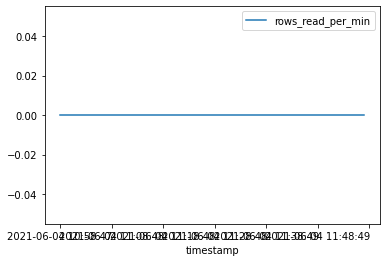

In [13]:
# Retrieve the number of rows read over the last day
# List the last 10 data points
# Graph the history

endTime = int(time.time())*1000
oneHour = 3600000
# Return the rows read rate over the last hour
r = databaseAPI.getRowsRead((endTime-oneHour), endTime)
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    if json['count'] > 0:
        df = pd.DataFrame(json_normalize(json['timeseries'])) #extract just the timeseries data
        print('Available Columns')
        print(', '.join(list(df)))
        # Convert from EPOCH to timeseries data
        df['timestamp'] = df['timestamp'].apply(epochtotimeseries)
        display(df[['timestamp','rows_read_per_min']].tail(20))
        df.plot.line(x='timestamp',y='rows_read_per_min') 
        plt.show()
    else: 
        print('No data returned')
else:
    print(databaseAPI.getStatusCode(r))

### Storage Usage
You can access the storage report page directly by calling it into an IFrame or you can access the data from an API. In the report below you can select the timeframe for storage usage, group by table or schema, select the object you want to analyze and then select View Details from the Actions column.

In [14]:
print(database+'/console/?mode=compact#monitor/storage'+profileURL)

http://services-uscentral.skytap.com:18638/console/?mode=compact#monitor/storage?profile=Ontime


You can also list storage by schema. The following example retrieves the current level of storage usage. 

In [ ]:
# List storage used by schema
# Display the top ten schemas
r = databaseAPI.getTableStorageBySchema()
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)        
    if json['count'] > 0: 
        df = pd.DataFrame(json_normalize(json['resources']))
        print(', '.join(list(df)))
        df['space_mb'] = df['data_physical_size_kb'].apply(lambda x: x / 1024)
        df = df.sort_values(by='data_physical_size_kb', ascending=False)    
        display(df[['tabschema','space_mb']].head(10))
    else: 
        print('No data returned') 
else:
    print("RC: "+str(databaseAPI.getStatusCode(r)))    

### Object Management
You can explore the objects in your database through the search objects API. This API requires an JSON payload to define the search criteria which can be complex. In this example we are looking for Views with "table" in their name. It will search through both user and catalog views. 

In [ ]:
# Search for tables across all schemas that match simple search critera 
# Display the first 100
# Switch between searching tables or views
object = 'view'
# object = 'table'
r = databaseAPI.postSearchObjects(object,"TABLE",10,'true','false')
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    df = pd.DataFrame(json_normalize(json))
    print('Columns:')
    print(', '.join(list(df)))
    display(df[[object+'_name']].head(100))
else:
    print("RC: "+str(databaseAPI.getStatusCode(r)))

This example returns all the tables in a single schema. 

In [ ]:
# Find all the tables in the SYSIBM schema and display the first 10
schema = 'SYSIBM'
r = databaseAPI.getTablesInSchema(schema)
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    df = pd.DataFrame(json_normalize(json['resources']))
    print(', '.join(list(df)))
    display(df[['schema','name']].head(10))
else:
    print(databaseAPI.getStatusCode(r))   

### Statement Monitoring
You can also review the currently running or "In-Flight" statements in the database. Both a user interface as well as a REST call are available. 
When the interface below appears, select the SYS icon at the right side of the page. This will display both the user statements as well as those statements initiated by the Db2 Data Management Console to monitor your database. You can also choose a longer timeframe to see a history of the statements that were running when the console polled the database. This happens every few minutes. 

In [ ]:
URL = database+'/console/?mode=compact#monitor/inflight_executions'+profileURL
print(URL)

You can retrieve the same information using a REST call. The example below only looks at what is running right now and it includes all statements. 

In [ ]:
# Retrieve the current statements running now
# Display the top 10 by execution time
r = databaseAPI.getInflightCurrentList()
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    if json['count'] > 0:
        df = pd.DataFrame(json_normalize(json['resources']))
        print('Columns')
        print(', '.join(list(df)))
        df = df.sort_values(by='exec_time_ms', ascending=False)
        display(df[['application_name','stmt_text','exec_time_ms','estimated_runtime_ms']].head(10))
    else:
        print('No data returned')
else:
    code = databaseAPI.getStatusCode(r)
    databaseAPI.printResponse(r, code)

You can also retrieve the current package cache list. The example below returns a list of all the statements currently in the package cache. There are more examples of using this with active workloads in the [Analysing SQL Workloads](http://localhost:8888/notebooks/Db2_Data_Management_Console_SQL.ipynb) notebook. 

In [ ]:
# Retrieve the current package cache list 
# sorted by the statement execution time
databaseAPI.authenticate(user, password, profile)
r = databaseAPI.getCurrentPackageCacheList("false")
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    if json['count'] > 0:  
        df = pd.DataFrame(json_normalize(json['resources']))
        df = df.sort_values(by='stmt_exec_time_ms', ascending=False)
        display(df[['stmt_text','stmt_exec_time_ms','stmtid']])
    else: 
        print('No data returned')  
else:
    print(databaseAPI.getStatusCode(r))

### Connection Monitoring
This next example demonstrates how to see what applications are connected to your database. Try clicking on the SYS icon at the right to show or hide the applications associated with the Db2 Data Management Console monitoring service. You can also choose different timeframes in this view to see the history of database connections. 

In [ ]:
URL = database+'/console/?mode=compact#monitor/connections'+profileURL
print(URL)

This next example retrieves the 10 most recently started database connections. You should be able to see the python application in the list, which is coming from this notebook. UC_MYMON is the Db2 Data Management Console monitoring service. Take a look at the columns returned in the JSON structure. You may want to try re-running this cell with different columns is the display command.

In [ ]:
# Display the 10 most recently started Database Connections
r = databaseAPI.getCurrentApplicationsConnections()
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    if json['count'] > 0: 
        df = pd.DataFrame(json_normalize(json['resources']))
        print(', '.join(list(df)))
        df = df.sort_values(by='connection_start_time', ascending=False)
        df['connection_start_time'] = df['connection_start_time'].apply(epochtotimeseries)
        # Try different columns from the list below and explore the additional data available. 
        display(df[['application_name','application_handle','connection_start_time']].head(10))
    else: 
        print('No data returned')  
else:
    print(databaseAPI.getStatusCode(r))

### Managing Your History Database
In this hands on lab, there are two databases in use. So far you have been connected to the SAMPLE database. The other database, HISTORY stores all the monitoring data collected by the Db2 Data Management Console monitoring service.

If we connect to the HISTORY database we can check the history of how much data is being collected over time by the monitoring service.

In this next cell we will switch from the SAMPLE to the HISTORY database. 

In [15]:
# Connect to the Db2 Data Management Console service
Console  = 'http://localhost:11080'
profile  = 'Repository'
user     = 'DB2INST1'
password = 'db2inst1'

# Set up the required connection
profileURL = "?profile="+profile
databaseAPI = Db2(Console+'/dbapi/v4')
databaseAPI.authenticate(user, password, profile)
database = Console

This next cell retrieves the storage history for the Historical Data Repostory stored in IBMCONSOLE schema. If this doesn't run against the repository database you will get a zero result set. 

Columns
timestamp, tabschema, data_logical_size_kb, index_logical_size_kb, long_logical_size_kb, lob_logical_size_kb, xml_logical_size_kb, column_organized_data_logical_size_kb, total_logical_size_kb, data_physical_size_kb, index_physical_size_kb, long_physical_size_kb, lob_physical_size_kb, xml_physical_size_kb, column_organized_data_physical_size_kb, total_physical_size_kb, estimated_reclaim_size_kb


,timestamp,total_physical_size_gb
0,2021-05-09 00:00:03,0.149536
1,2021-05-09 00:00:11,0.149536


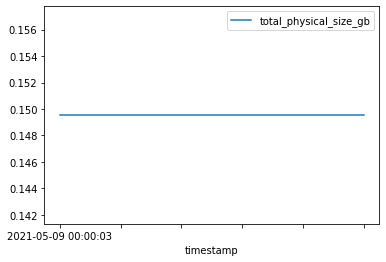

In [16]:
# List the last 10 data points
# Graph the history of the storage usage
tabSchema = 'IBMCONSOLE'
OneWeekStartTime = endTime - oneWeek
r = databaseAPI.getSchemaSize(0, endTime, tabSchema)
if (databaseAPI.getStatusCode(r)==200):
    json = databaseAPI.getJSON(r)
    if json['count'] > 0: 
        df = pd.DataFrame(json_normalize(json['timeseries']))
        print('Columns')
        print(', '.join(list(df)))
        df['total_physical_size_gb'] = df['total_physical_size_kb'].apply(KBtoGB)
        df['timestamp'] = df['timestamp'].apply(epochtotimeseries)
        display(df[['timestamp','total_physical_size_gb']].tail(10))
        df.plot(x='timestamp',y='total_physical_size_gb')
    else: 
        print('No data returned') 
else:
    print(databaseAPI.getStatusCode(r))

### Next Steps
Try the [Analysing SQL Workloads](http://localhost:8888/notebooks/Db2_Data_Management_Console_SQL.ipynb). It contains extensive examples on how to run workloads that contain multiple SQL Statements across multiple databases and then measure their performance. 

Also try building some of your own reports based on the examples in this hands on lab. There are additional functions included in the Db2 class that we haven't explored yet in this lab. You can also include the Db2 class into your own notebook by including the [dmc_setup notebook](http://localhost:8888/notebooks/dmc_setup.ipynb)

#### Credits: IBM 2019-2021, Peter Kohlmann [kohlmann@ca.ibm.com]